# Basic characteristics of boundary layer decoupling in warm advection

In [5]:
# setting up everything
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import glob
import seaborn as sns
import os

from matplotlib import cm
%matplotlib inline

In [6]:
#read data
path="C:/Data/ASTEXT_output/3D/OUT_STAT/"

tmp = glob.glob(path + "*warm*.nc")
f_wadv  = xr.open_dataset(tmp[0])

tmp = glob.glob(path + '*cold*.nc')
f_cadv  = xr.open_dataset(tmp[0])

tmp = glob.glob(path + '*zero*.nc')
f_0adv  = xr.open_dataset(tmp[0])

In [7]:
# defining a function for axe plotting
def make_axis(ioax, iax, ititle, ictitle, ifsize):
    cbar = fig.colorbar(ioax, ax = iax)
    cbar.set_label(ictitle, fontsize=ifsize)

    iax.set_ylim([0., 2000])
    iax.set_xlabel('Hours', fontsize=ifsize)  # Add an x-label to the axes.
    iax.set_ylabel('Height (m)', fontsize=ifsize)  # Add a y-label to the axes.
    iax.grid(True)
    iax.set_title(ititle, fontsize=ifsize)

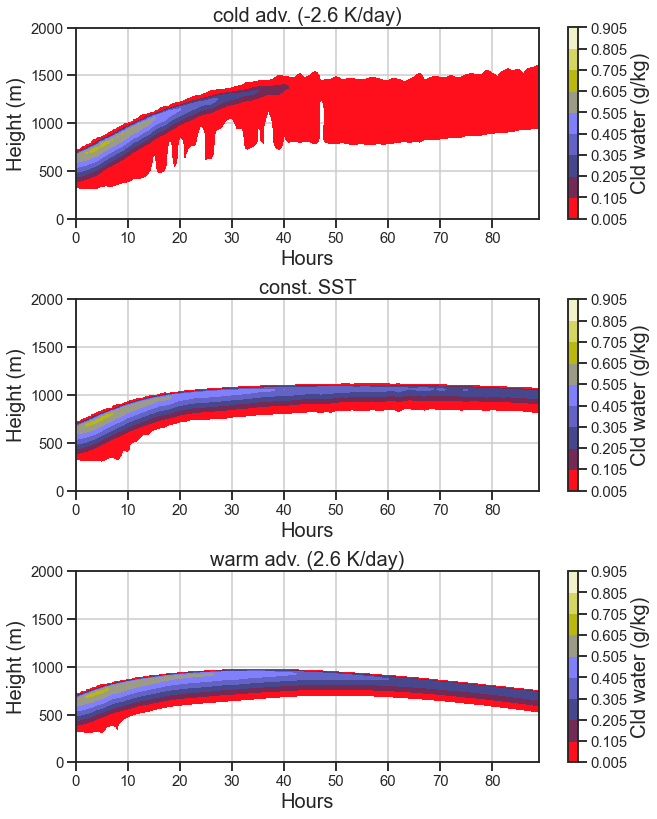

In [31]:
sns.set(context="talk", style="ticks", font_scale=0.9)
z = f_cadv['z'].values/1000.
t = f_cadv['time'].values
nz = len(z)
nt = len(t)

#Plot basic features of cloud field
x = np.arange(nt)
y = f_wadv['z']

fig, (ax, ax2, ax3) = plt.subplots(3,1,figsize=(10, 12))  # Create a figure and an axes.
myfontsize = 20
fig.tight_layout(pad=3.0)

#fig1 
var = f_cadv['QC']
var = var.T

oax = ax.contourf(x,y,var, cmap = cm.gist_stern, levels = np.arange(0.005,1.,0.1))
make_axis(oax, ax, 'cold adv. (-2.6 K/day)', 'Cld water (g/kg)', myfontsize)

#fig2 
var = f_0adv['QC']
var = var.T

oax = ax2.contourf(x,y,var, cmap = cm.gist_stern, levels = np.arange(0.005,1.,0.1))
make_axis(oax, ax2, 'const. SST', 'Cld water (g/kg)', myfontsize)

#fig3
var = f_wadv['QC']
var = var.T

oax = ax3.contourf(x,y,var, cmap = cm.gist_stern, levels = np.arange(0.005,1.,0.1))
make_axis(oax, ax3, 'warm adv. (2.6 K/day)', 'Cld water (g/kg)', myfontsize)

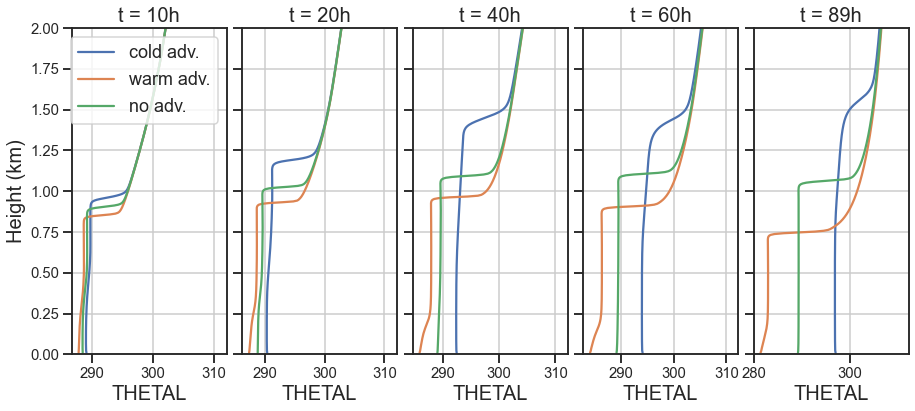

In [18]:
# profiles of temperature and moisture
y = f_cadv['z']/1000.
# var_use = ["THETAL","QT", "QT","QT","QT"]
time_use = [10, 20, 40, 60, 89]

fig, axs = plt.subplots(1,5, figsize=(15, 6))
fig.subplots_adjust(wspace=.1)

axs = axs.ravel()
for i in range(5):
    x = f_cadv["THETAL"]
    axs[i].plot(x[time_use[i],:], y, label='cold adv.')
    
    x = f_wadv["THETAL"]
    axs[i].plot(x[time_use[i],:], y, label='warm adv.')
    
    x = f_0adv["THETAL"]
    axs[i].plot(x[time_use[i],:], y, label='no adv.')
    
    axs[i].set_ylim([0., 2])
    axs[i].set_xlabel('THETAL', fontsize=myfontsize)  # Add an x-label to the axes.
    axs[i].grid(True)
    axs[i].set_title('t = ' + str(time_use[i]) + ' h', fontsize=myfontsize)
    
    if i > 0:
        axs[i].yaxis.set_major_formatter(plt.NullFormatter())
    
    if i==0:
        axs[i].set_ylabel('Height (km)', fontsize=myfontsize)  # Add a y-label to the axes.
        axs[i].legend(loc=1, fontsize=18)

## Notes
- Comparison of absolute thetal is not very informative. Should compare scaled thetal.

In [60]:
# To calculate the values at the stratocumulus base height, cloud top and inversion base height
def get_hgt3(var, cld, thl2):

    # z_bottom
    zb_ind = 0
    for k in np.arange(nz)[::-1]:
        if (cld[k] > 0.6):
            zb_ind = k
    var_b = var[zb_ind]

    # z_top, same as z_plus (i.e., inversion top height)
    thl2_max_ind=np.argmax(thl2)
    thl2_max = thl2[thl2_max_ind]
    for i in np.arange(thl2_max_ind,nz,1):
        if (thl2[i] > 0.05*thl2_max ):
            zp_ind = i
    var_t = var[zp_ind]+(thl2_max*0.05-thl2[zp_ind])/(thl2[zp_ind+1]-thl2[zp_ind])*(var[zp_ind+1]-var[zp_ind])

    # z_minus, inversion base height
    # zm_ind = 0
    for i in np.arange(0,thl2_max_ind,1)[::-1]:
        if (thl2[i] > 0.05*thl2_max ):
            zm_ind = i
    var_m = var[zm_ind]+(thl2_max*0.05-thl2[zm_ind])/(thl2[zm_ind-1]-thl2[zm_ind])*(var[zm_ind-1]-var[zm_ind])

    return var_t, var_b, var_m

In [65]:
# compute scaling parameters
zinvb_wadv = np.zeros(nt)
zinvb_cadv = np.zeros(nt)
zinvb_0adv = np.zeros(nt)

zb_wadv = np.zeros(nt)
zb_cadv = np.zeros(nt)
zb_0adv = np.zeros(nt)

thetal_vmean_wadv = np.zeros(nt)
thetal_vmean_cadv = np.zeros(nt)
thetal_vmean_0adv = np.zeros(nt)

qt_vmean_wadv = np.zeros(nt)
qt_vmean_cadv = np.zeros(nt)
qt_vmean_0adv = np.zeros(nt)

qtflux_vmean_wadv = np.zeros(nt)
qtflux_vmean_cadv = np.zeros(nt)
qtflux_vmean_0adv = np.zeros(nt)

for ii in np.arange(nt):
    
    cld = f_cadv['CLD'].values[ii,:] # cloud fraction
    thl2 = f_cadv['THL2'].values[ii,:] 
    thl  = f_cadv['THETAL'].values[ii,:] 
    qt   = f_cadv['QT'].values[ii,:] 
    qtflux   = f_cadv['QTFLUX'].values[ii,:] 
    tmp,zb_cadv[ii],zinvb_cadv[ii] = get_hgt3(z, cld, thl2)
    ind = (z < zinvb_cadv[ii])
    thetal_vmean_cadv[ii] = np.average(thl[ind])
    qt_vmean_cadv[ii] = np.average(qt[ind])
    qtflux_vmean_cadv[ii] = np.average(qtflux[ind])
    
    cld = f_wadv['CLD'].values[ii,:] # cloud fraction
    thl2 = f_wadv['THL2'].values[ii,:] 
    thl  = f_wadv['THETAL'].values[ii,:] 
    qt   = f_wadv['QT'].values[ii,:] 
    qtflux   = f_wadv['QTFLUX'].values[ii,:] 
    tmp,zb_wadv[ii],zinvb_wadv[ii] = get_hgt3(z, cld, thl2)
    ind = (z < zinvb_wadv[ii])
    thetal_vmean_wadv[ii] = np.average(thl[ind])
    qt_vmean_wadv[ii] = np.average(qt[ind])
    qtflux_vmean_wadv[ii] = np.average(qtflux[ind])
    
    cld = f_0adv['CLD'].values[ii,:] # cloud fraction
    thl2 = f_0adv['THL2'].values[ii,:] 
    thl  = f_0adv['THETAL'].values[ii,:] 
    qt   = f_0adv['QT'].values[ii,:] 
    qtflux   = f_0adv['QTFLUX'].values[ii,:] 
    tmp,zb_0adv[ii],zinvb_0adv[ii] = get_hgt3(z, cld, thl2)
    ind = (z < zinvb_0adv[ii])
    thetal_vmean_0adv[ii] = np.average(thl[ind])
    qt_vmean_0adv[ii] = np.average(qt[ind])
    qtflux_vmean_0adv[ii] = np.average(qtflux[ind])

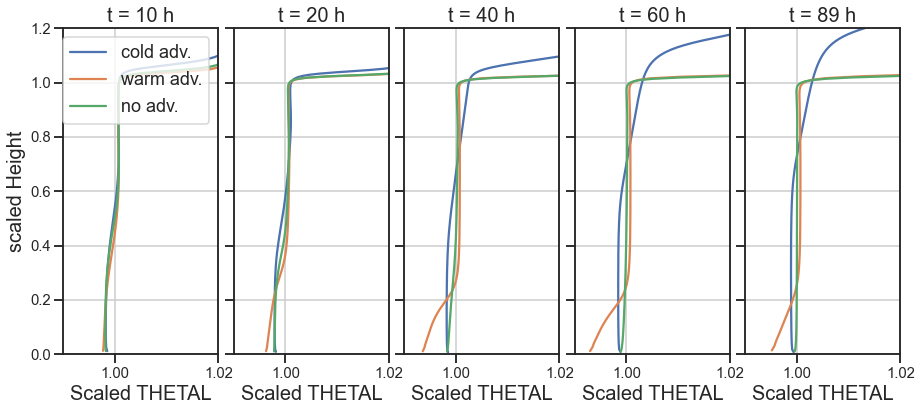

In [52]:
# profiles of scaled temperature and moisture
time_use = [10, 20, 40, 60, 89]

fig, axs = plt.subplots(1,5, figsize=(15, 6))
fig.subplots_adjust(wspace=.1)

axs = axs.ravel()
for i in range(5):
    x = f_cadv["THETAL"].values[time_use[i]]/thetal_vmean_cadv[time_use[i]]
    y = z/zinvb_cadv[time_use[i]]
    axs[i].plot(x, y, label='cold adv.')
    
    x = f_wadv["THETAL"].values[time_use[i]]/thetal_vmean_wadv[time_use[i]]
    y = z/zinvb_wadv[time_use[i]]
    axs[i].plot(x, y, label='warm adv.')
    
    x = f_0adv["THETAL"].values[time_use[i]]/thetal_vmean_0adv[time_use[i]]
    y = z/zinvb_0adv[time_use[i]]
    axs[i].plot(x, y, label='no adv.')
    
    axs[i].set_ylim([0., 1.2])
    axs[i].set_xlim([0.99, 1.02])
    axs[i].set_xlabel('Scaled THETAL', fontsize=myfontsize)  # Add an x-label to the axes.
    axs[i].grid(True)
    axs[i].set_title('t = ' + str(time_use[i]) + ' h', fontsize=myfontsize)
    
    if i > 0:
        axs[i].yaxis.set_major_formatter(plt.NullFormatter())
    
    if i==0:
        axs[i].set_ylabel('scaled Height', fontsize=myfontsize)  # Add a y-label to the axes.
        axs[i].legend(loc=1, fontsize=18)

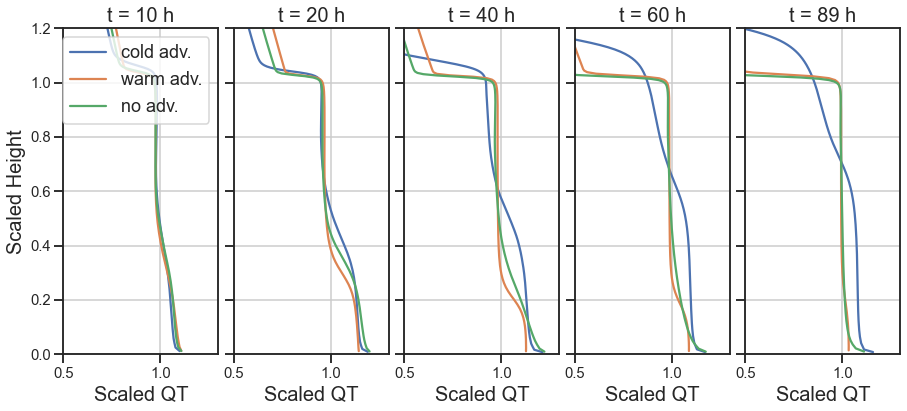

In [46]:
fig, axs = plt.subplots(1,5, figsize=(15, 6))
fig.subplots_adjust(wspace=.1)

axs = axs.ravel()
for i in range(5):
    x = f_cadv["QT"].values[time_use[i]]/qt_vmean_cadv[time_use[i]]
    y = z/zinvb_cadv[time_use[i]]
    axs[i].plot(x, y, label='cold adv.')
    
    x = f_wadv["QT"].values[time_use[i]]/qt_vmean_wadv[time_use[i]]
    y = z/zinvb_wadv[time_use[i]]
    axs[i].plot(x, y, label='warm adv.')
    
    x = f_0adv["QT"].values[time_use[i]]/qt_vmean_0adv[time_use[i]]
    y = z/zinvb_0adv[time_use[i]]
    axs[i].plot(x, y, label='no adv.')
    
    axs[i].set_ylim([0., 1.2])
    axs[i].set_xlim([0.5, 1.3])
    axs[i].set_xlabel('Scaled QT', fontsize=myfontsize)  # Add an x-label to the axes.
    axs[i].grid(True)
    axs[i].set_title('t = ' + str(time_use[i]) + ' h', fontsize=myfontsize)
    
    if i > 0:
        axs[i].yaxis.set_major_formatter(plt.NullFormatter())
    
    if i==0:
        axs[i].set_ylabel('Scaled Height', fontsize=myfontsize)  # Add a y-label to the axes.
        axs[i].legend(loc=1, fontsize=18)

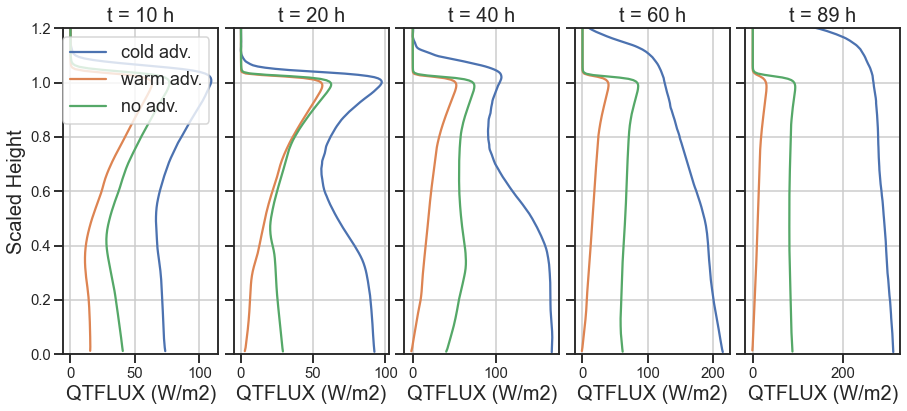

In [53]:
fig, axs = plt.subplots(1,5, figsize=(15, 6))
fig.subplots_adjust(wspace=.1)

axs = axs.ravel()
for i in range(5):
    x = f_cadv["QTFLUX"].values[time_use[i]]
    y = z/zinvb_cadv[time_use[i]]
    axs[i].plot(x, y, label='cold adv.')
    
    x = f_wadv["QTFLUX"].values[time_use[i]]
    y = z/zinvb_wadv[time_use[i]]
    axs[i].plot(x, y, label='warm adv.')
    
    x = f_0adv["QTFLUX"].values[time_use[i]]
    y = z/zinvb_0adv[time_use[i]]
    axs[i].plot(x, y, label='no adv.')
    
    axs[i].set_ylim([0., 1.2])
#     axs[i].set_xlim([0.5, 1.3])
    axs[i].set_xlabel('QTFLUX (W/m2)', fontsize=myfontsize)  # Add an x-label to the axes.
    axs[i].grid(True)
    axs[i].set_title('t = ' + str(time_use[i]) + ' h', fontsize=myfontsize)
    
    if i > 0:
        axs[i].yaxis.set_major_formatter(plt.NullFormatter())
    
    if i==0:
        axs[i].set_ylabel('Scaled Height', fontsize=myfontsize)  # Add a y-label to the axes.
        axs[i].legend(loc=1, fontsize=18)

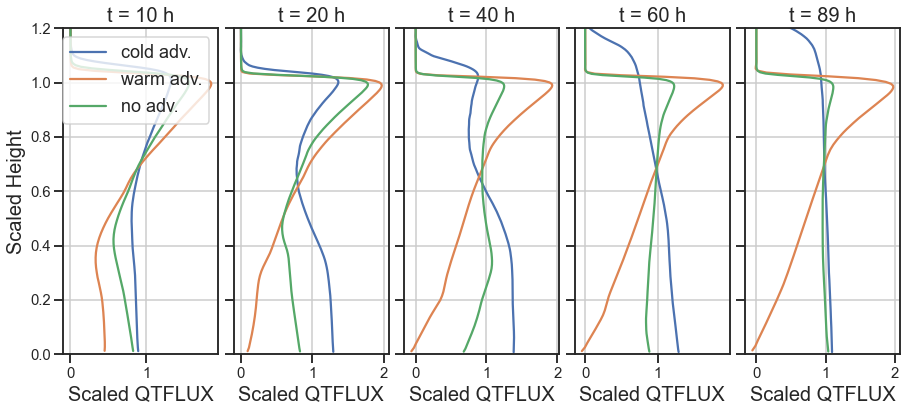

In [54]:
fig, axs = plt.subplots(1,5, figsize=(15, 6))
fig.subplots_adjust(wspace=.1)

axs = axs.ravel()
for i in range(5):
    x = f_cadv["QTFLUX"].values[time_use[i]]/qtflux_vmean_cadv[time_use[i]]
    y = z/zinvb_cadv[time_use[i]]
    axs[i].plot(x, y, label='cold adv.')
    
    x = f_wadv["QTFLUX"].values[time_use[i]]/qtflux_vmean_wadv[time_use[i]]
    y = z/zinvb_wadv[time_use[i]]
    axs[i].plot(x, y, label='warm adv.')
    
    x = f_0adv["QTFLUX"].values[time_use[i]]/qtflux_vmean_0adv[time_use[i]]
    y = z/zinvb_0adv[time_use[i]]
    axs[i].plot(x, y, label='no adv.')
    
    axs[i].set_ylim([0., 1.2])
#     axs[i].set_xlim([0.5, 1.3])
    axs[i].set_xlabel('Scaled QTFLUX', fontsize=myfontsize)  # Add an x-label to the axes.
    axs[i].grid(True)
    axs[i].set_title('t = ' + str(time_use[i]) + ' h', fontsize=myfontsize)
    
    if i > 0:
        axs[i].yaxis.set_major_formatter(plt.NullFormatter())
    
    if i==0:
        axs[i].set_ylabel('Scaled Height', fontsize=myfontsize)  # Add a y-label to the axes.
        axs[i].legend(loc=1, fontsize=18)

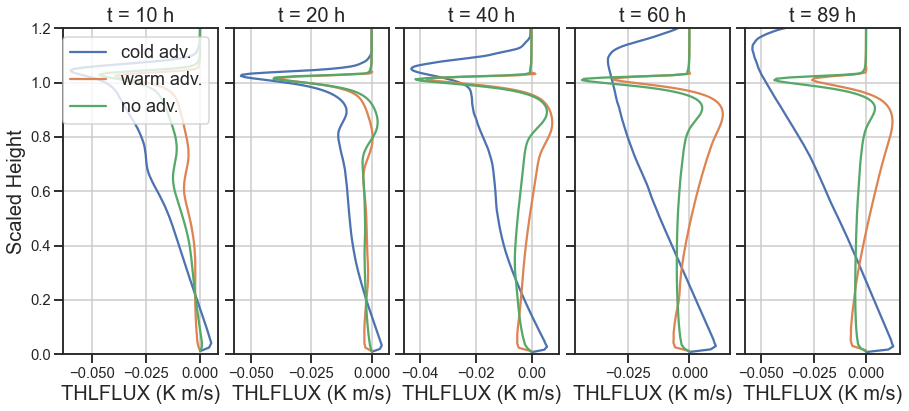

In [56]:
fig, axs = plt.subplots(1,5, figsize=(15, 6))
fig.subplots_adjust(wspace=.1)

axs = axs.ravel()
for i in range(5):
    x = f_cadv["THLFLUX"].values[time_use[i]]
    y = z/zinvb_cadv[time_use[i]]
    axs[i].plot(x, y, label='cold adv.')
    
    x = f_wadv["THLFLUX"].values[time_use[i]]
    y = z/zinvb_wadv[time_use[i]]
    axs[i].plot(x, y, label='warm adv.')
    
    x = f_0adv["THLFLUX"].values[time_use[i]]
    y = z/zinvb_0adv[time_use[i]]
    axs[i].plot(x, y, label='no adv.')
    
    axs[i].set_ylim([0., 1.2])
#     axs[i].set_xlim([0.5, 1.3])
    axs[i].set_xlabel('THLFLUX (K m/s)', fontsize=myfontsize)  # Add an x-label to the axes.
    axs[i].grid(True)
    axs[i].set_title('t = ' + str(time_use[i]) + ' h', fontsize=myfontsize)
    
    if i > 0:
        axs[i].yaxis.set_major_formatter(plt.NullFormatter())
    
    if i==0:
        axs[i].set_ylabel('Scaled Height', fontsize=myfontsize)  # Add a y-label to the axes.
        axs[i].legend(loc=1, fontsize=18)

In [57]:
f_cadv

<xarray.Dataset>
Dimensions:     (time: 90, z: 512)
Coordinates:
  * z           (z) float32 10.5 22.5 37.5 52.5 ... 3939.8 4055.5 4182.2 4320.9
  * time        (time) float32 165.02083 165.0625 ... 168.6875 168.72917
Data variables:
    p           (z) float32 ...
    SST         (time) float32 ...
    Ps          (time) float32 ...
    CLDSHD      (time) float32 ...
    AREAPREC    (time) float32 ...
    CLD245      (time) float32 ...
    WMAX        (time) float32 ...
    UMAX        (time) float32 ...
    PREC        (time) float32 ...
    LHF         (time) float32 ...
    SHF         (time) float32 ...
    PW          (time) float32 ...
    PWOBS       (time) float32 ...
    CWP         (time) float32 ...
    IWP         (time) float32 ...
    RWP         (time) float32 ...
    SWP         (time) float32 ...
    GWP         (time) float32 ...
    CAPE        (time) float32 ...
    CAPEOBS     (time) float32 ...
    CIN         (time) float32 ...
    CINOBS      (time) float32 ...
    LWNS        (time) float32 ...
    LWNT        (time) float32 ...
    LWNTOA      (time) float32 ...
    LWNSC       (time) float32 ...
    LWNTOAC     (time) float32 ...
    LWDS        (time) float32 ...
    SWNS        (time) float32 ...
    SWNT        (time) float32 ...
    SWNTOA      (time) float32 ...
    SWNSC       (time) float32 ...
    SWNTOAC     (time) float32 ...
    SWDS        (time) float32 ...
    SOLIN       (time) float32 ...
    SSTOBS      (time) float32 ...
    LHFOBS      (time) float32 ...
    SHFOBS      (time) float32 ...
    CLDLOW      (time) float32 ...
    CLDMID      (time) float32 ...
    CLDHI       (time) float32 ...
    ISCCPTOT    (time) float32 ...
    ISCCPLOW    (time) float32 ...
    ISCCPMID    (time) float32 ...
    ISCCPHGH    (time) float32 ...
    MODISTOT    (time) float32 ...
    MODISLOW    (time) float32 ...
    MODISMID    (time) float32 ...
    MODISHGH    (time) float32 ...
    MISRTOT     (time) float32 ...
    MODISREL    (time) float32 ...
    MODISREI    (time) float32 ...
    MODISLWP    (time) float32 ...
    MODISIWP    (time) float32 ...
    ISCCPTB     (time) float32 ...
    ISCCPTBCLR  (time) float32 ...
    MODISTOTL   (time) float32 ...
    MODISTOTI   (time) float32 ...
    ISCCPTAU    (time) float32 ...
    ISCCPALB    (time) float32 ...
    ISCCPPTOP   (time) float32 ...
    MODISTAU    (time) float32 ...
    MODISTAUL   (time) float32 ...
    MODISTAUI   (time) float32 ...
    MODISPTOP   (time) float32 ...
    MISRZTOP    (time) float32 ...
    ZINV        (time) float32 ...
    ZINV2       (time) float32 ...
    ZCT         (time) float32 ...
    ZCT2        (time) float32 ...
    ZCTMAX      (time) float32 ...
    ZCB         (time) float32 ...
    ZCB2        (time) float32 ...
    ZCBMIN      (time) float32 ...
    LWP         (time) float32 ...
    LWP2        (time) float32 ...
    PRECMN      (time) float32 ...
    PREC2       (time) float32 ...
    PRECMAX     (time) float32 ...
    NCMN        (time) float32 ...
    NRMN        (time) float32 ...
    AREAPRTHR   (time) float32 ...
    we          (time) float32 ...
    Tend_lwp    (time) float32 ...
    PRES        (time, z) float32 ...
    U           (time, z) float32 ...
    V           (time, z) float32 ...
    UOBS        (time, z) float32 ...
    VOBS        (time, z) float32 ...
    WOBS        (time, z) float32 ...
    RHO         (time, z) float32 ...
    MSE         (time, z) float32 ...
    DSE         (time, z) float32 ...
    SSE         (time, z) float32 ...
    THETAE      (time, z) float32 ...
    THETA       (time, z) float32 ...
    THETAV      (time, z) float32 ...
    THETAL      (time, z) float32 288.12988 288.06158 ... 310.29614 310.74567
    TABS        (time, z) float32 ...
    TABSOBS     (time, z) float32 ...
    TL          (time, z) float32 ...
    QT          (time, z) float32 10.634073 10.41068 ... 1.475976 1.390516
    QV          (time, z) float32 ...
    QVOBS       (time, z) floa

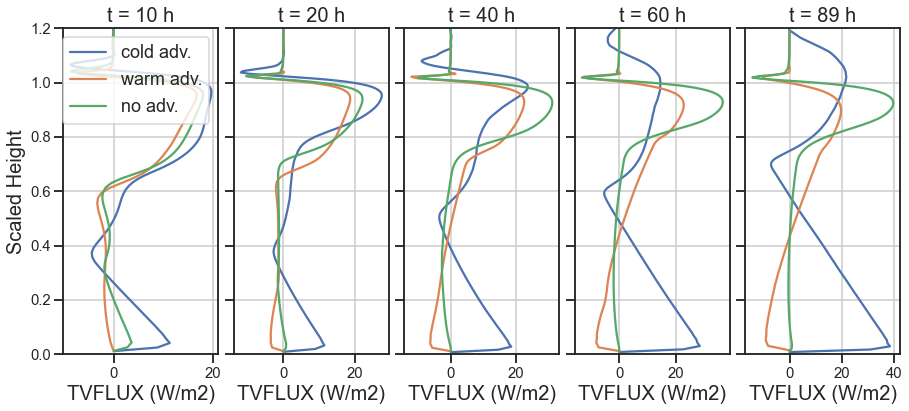

In [59]:
fig, axs = plt.subplots(1,5, figsize=(15, 6))
fig.subplots_adjust(wspace=.1)

axs = axs.ravel()
for i in range(5):
    x = f_cadv["TVFLUX"].values[time_use[i]]
    y = z/zinvb_cadv[time_use[i]]
    axs[i].plot(x, y, label='cold adv.')
    
    x = f_wadv["TVFLUX"].values[time_use[i]]
    y = z/zinvb_wadv[time_use[i]]
    axs[i].plot(x, y, label='warm adv.')
    
    x = f_0adv["TVFLUX"].values[time_use[i]]
    y = z/zinvb_0adv[time_use[i]]
    axs[i].plot(x, y, label='no adv.')
    
    axs[i].set_ylim([0., 1.2])
#     axs[i].set_xlim([0.5, 1.3])
    axs[i].set_xlabel('TVFLUX (W/m2)', fontsize=myfontsize)  # Add an x-label to the axes.
    axs[i].grid(True)
    axs[i].set_title('t = ' + str(time_use[i]) + ' h', fontsize=myfontsize)
    
    if i > 0:
        axs[i].yaxis.set_major_formatter(plt.NullFormatter())
    
    if i==0:
        axs[i].set_ylabel('Scaled Height', fontsize=myfontsize)  # Add a y-label to the axes.
        axs[i].legend(loc=1, fontsize=18)

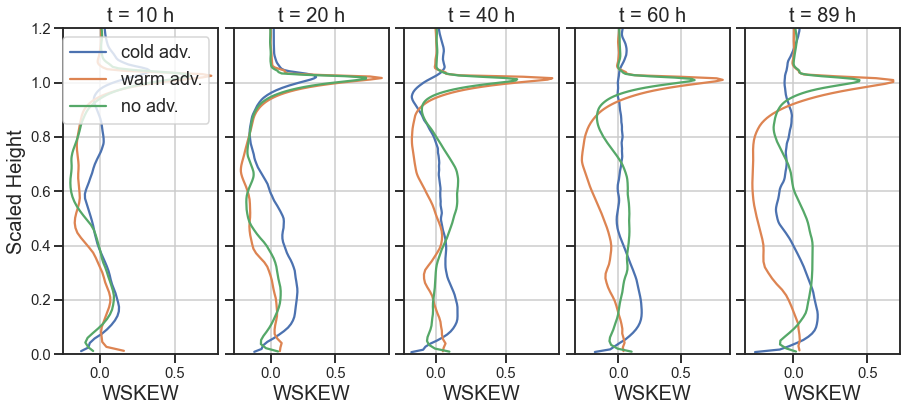

In [62]:
fig, axs = plt.subplots(1,5, figsize=(15, 6))
fig.subplots_adjust(wspace=.1)

axs = axs.ravel()
for i in range(5):
    x = f_cadv["WSKEW"].values[time_use[i]]
    y = z/zinvb_cadv[time_use[i]]
    axs[i].plot(x, y, label='cold adv.')
    
    x = f_wadv["WSKEW"].values[time_use[i]]
    y = z/zinvb_wadv[time_use[i]]
    axs[i].plot(x, y, label='warm adv.')
    
    x = f_0adv["WSKEW"].values[time_use[i]]
    y = z/zinvb_0adv[time_use[i]]
    axs[i].plot(x, y, label='no adv.')
    
    axs[i].set_ylim([0., 1.2])
#     axs[i].set_xlim([0.5, 1.3])
    axs[i].set_xlabel('WSKEW', fontsize=myfontsize)  # Add an x-label to the axes.
    axs[i].grid(True)
    axs[i].set_title('t = ' + str(time_use[i]) + ' h', fontsize=myfontsize)
    
    if i > 0:
        axs[i].yaxis.set_major_formatter(plt.NullFormatter())
    
    if i==0:
        axs[i].set_ylabel('Scaled Height', fontsize=myfontsize)  # Add a y-label to the axes.
        axs[i].legend(loc=1, fontsize=18)

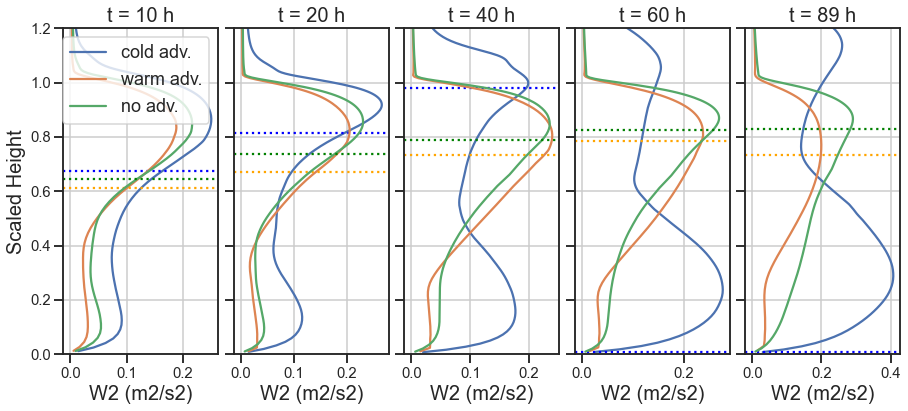

In [67]:
fig, axs = plt.subplots(1,5, figsize=(15, 6))
fig.subplots_adjust(wspace=.1)

axs = axs.ravel()
for i in range(5):
    x = f_cadv["W2"].values[time_use[i]]
    y = z/zinvb_cadv[time_use[i]]
    axs[i].plot(x, y, label='cold adv.')
    axs[i].axhline(y=zb_cadv[time_use[i]]/zinvb_cadv[time_use[i]], color='blue', linestyle='dotted')
    
    x = f_wadv["W2"].values[time_use[i]]
    y = z/zinvb_wadv[time_use[i]]
    axs[i].plot(x, y, label='warm adv.')
    axs[i].axhline(y=zb_wadv[time_use[i]]/zinvb_wadv[time_use[i]], color='orange', linestyle='dotted')
    
    x = f_0adv["W2"].values[time_use[i]]
    y = z/zinvb_0adv[time_use[i]]
    axs[i].plot(x, y, label='no adv.')
    axs[i].axhline(y=zb_0adv[time_use[i]]/zinvb_0adv[time_use[i]], color='green', linestyle='dotted')
    
    axs[i].set_ylim([0., 1.2])
#     axs[i].set_xlim([0.5, 1.3])
    axs[i].set_xlabel('W2 (m2/s2)', fontsize=myfontsize)  # Add an x-label to the axes.
    axs[i].grid(True)
    axs[i].set_title('t = ' + str(time_use[i]) + ' h', fontsize=myfontsize)
    
    if i > 0:
        axs[i].yaxis.set_major_formatter(plt.NullFormatter())
    
    if i==0:
        axs[i].set_ylabel('Scaled Height', fontsize=myfontsize)  # Add a y-label to the axes.
        axs[i].legend(loc=1, fontsize=18)